# RAG-Benchmark Results Analysis

**Analyse und Visualisierung der CLI-Experiment Ergebnisse**

**Author:** Lukas Schaumlöffel  
**Master Informatik (HAW Hamburg)**

## Übersicht

Dieses Notebook analysiert die Ergebnisse von `run_experiment.py` und erstellt Visualisierungen:

- **BLEU Score Vergleich** nach Methode
- **ROUGE Score Analyse**
- **Performance nach Schwierigkeit**
- **Retrieval Success Rates**
- **Durchschnittliche Antwortzeiten**

---

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Plot-Styling wie im Grundprojekt
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

%matplotlib inline

print("Setup abgeschlossen - bereit für Results-Analyse")

Setup abgeschlossen - bereit für Results-Analyse


## 1. Daten laden

In [27]:
# Ergebnisse-Verzeichnis
results_dir = Path("../results")

# Neueste Result-Files finden
pipeline_files = list(results_dir.glob('rag_pipeline_results_*.csv'))
eval_files = list(results_dir.glob('evaluation_scores_*.csv'))  
report_files = list(results_dir.glob('final_report_*.json'))

if not pipeline_files:
    print("Keine Pipeline-Ergebnisse gefunden. Führe zuerst aus:")
    print("python run_experiment.py --methods baseline,vector")
    raise FileNotFoundError("Keine Results-Files gefunden")

# Neueste Dateien laden
latest_pipeline = max(pipeline_files, key=lambda x: x.stat().st_mtime)
pipeline_df = pd.read_csv(latest_pipeline)
print(f"Pipeline Results geladen: {latest_pipeline.name}")
print(f"  Zeilen: {len(pipeline_df)}, Spalten: {len(pipeline_df.columns)}")

eval_df = None
if eval_files:
    latest_eval = max(eval_files, key=lambda x: x.stat().st_mtime)
    eval_df = pd.read_csv(latest_eval)
    print(f"Evaluation Results geladen: {latest_eval.name}")
    print(f"  Zeilen: {len(eval_df)}, Spalten: {len(eval_df.columns)}")

report_data = None
if report_files:
    latest_report = max(report_files, key=lambda x: x.stat().st_mtime)
    with open(latest_report, 'r', encoding='utf-8') as f:
        report_data = json.load(f)
    print(f"Final Report geladen: {latest_report.name}")

print("\nDatenübersicht:")
print(f"Getestete Methoden: {pipeline_df['method'].unique() if 'method' in pipeline_df.columns else 'N/A'}")
print(f"Anzahl Fragen: {pipeline_df['question_id'].nunique() if 'question_id' in pipeline_df.columns else 'N/A'}")

Pipeline Results geladen: rag_pipeline_results_20250827_184241.csv
  Zeilen: 48, Spalten: 11
Evaluation Results geladen: evaluation_scores_20250827_184241.csv
  Zeilen: 48, Spalten: 10
Final Report geladen: final_report_20250827_184241.json

Datenübersicht:
Getestete Methoden: ['baseline' 'vector' 'graph' 'hybrid']
Anzahl Fragen: 12


## 2. BLEU Score Vergleich (wie im Grundprojekt)

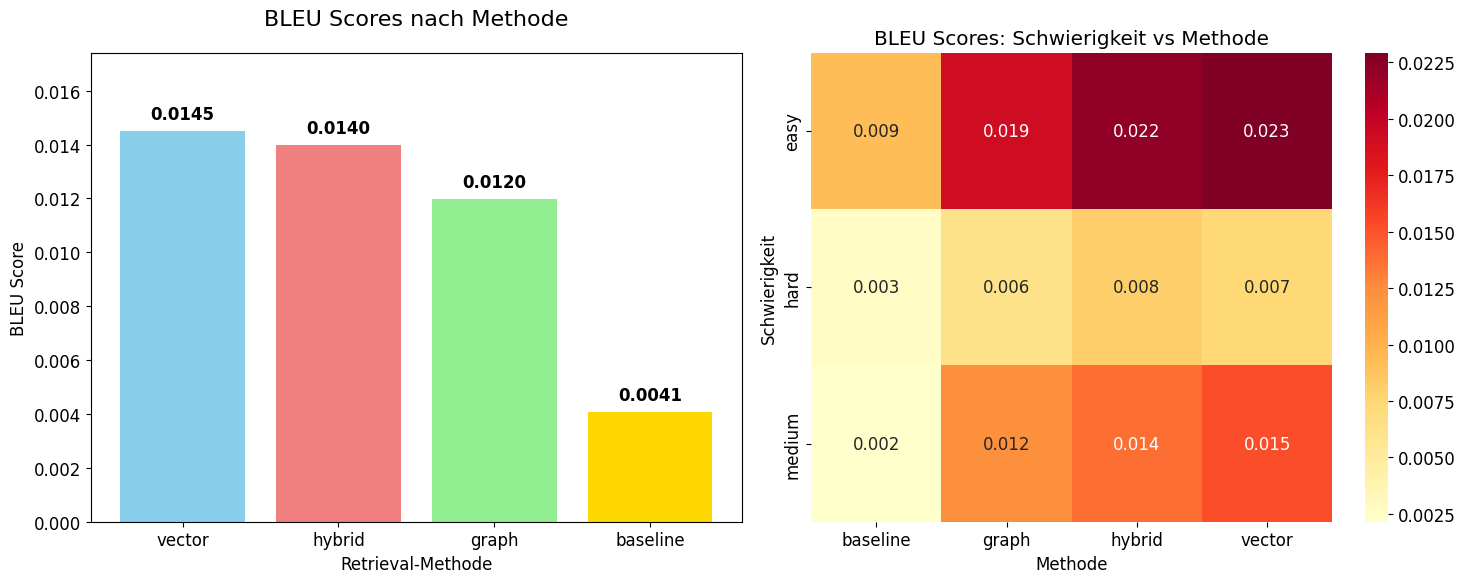

BLEU Score Zusammenfassung:
  method   mean  count    std
  vector 0.0145     12 0.0121
  hybrid 0.0140     12 0.0126
   graph 0.0120     12 0.0115
baseline 0.0041     12 0.0067


In [28]:
if eval_df is not None and 'bleu_score' in eval_df.columns:
    # BLEU Score nach Methode aggregieren
    bleu_by_method = eval_df.groupby('method')['bleu_score'].agg(['mean', 'count', 'std']).reset_index()
    bleu_by_method = bleu_by_method.sort_values('mean', ascending=False)
    
    # Hauptdiagramm: BLEU Scores nach Methode
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Balkendiagramm
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    bars = ax1.bar(bleu_by_method['method'], bleu_by_method['mean'], 
                   color=colors[:len(bleu_by_method)])
    ax1.set_title('BLEU Scores nach Methode', fontsize=16, pad=20)
    ax1.set_xlabel('Retrieval-Methode')
    ax1.set_ylabel('BLEU Score')
    ax1.set_ylim(0, bleu_by_method['mean'].max() * 1.2)
    
    # Werte auf Balken
    for bar, score in zip(bars, bleu_by_method['mean']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bleu_by_method['mean'].max()*0.02,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # BLEU Scores: Schwierigkeit vs Methode (Heatmap wie im Grundprojekt)
    if 'difficulty' in eval_df.columns:
        difficulty_pivot = eval_df.pivot_table(values='bleu_score', index='difficulty', 
                                              columns='method', aggfunc='mean')
        
        sns.heatmap(difficulty_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
        ax2.set_title('BLEU Scores: Schwierigkeit vs Methode')
        ax2.set_xlabel('Methode')
        ax2.set_ylabel('Schwierigkeit')
    else:
        ax2.text(0.5, 0.5, 'Keine Schwierigkeits-\nInformationen verfügbar', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=14)
        ax2.set_title('Schwierigkeitsanalyse nicht möglich')
    
    plt.tight_layout()
    plt.show()
    
    # Tabelle der Ergebnisse
    print("BLEU Score Zusammenfassung:")
    bleu_by_method['mean'] = bleu_by_method['mean'].round(4)
    bleu_by_method['std'] = bleu_by_method['std'].round(4)
    print(bleu_by_method[['method', 'mean', 'count', 'std']].to_string(index=False))
    
else:
    print("Keine BLEU-Score Daten gefunden. Evaluation möglicherweise fehlgeschlagen.")

## 3. ROUGE Score Analyse

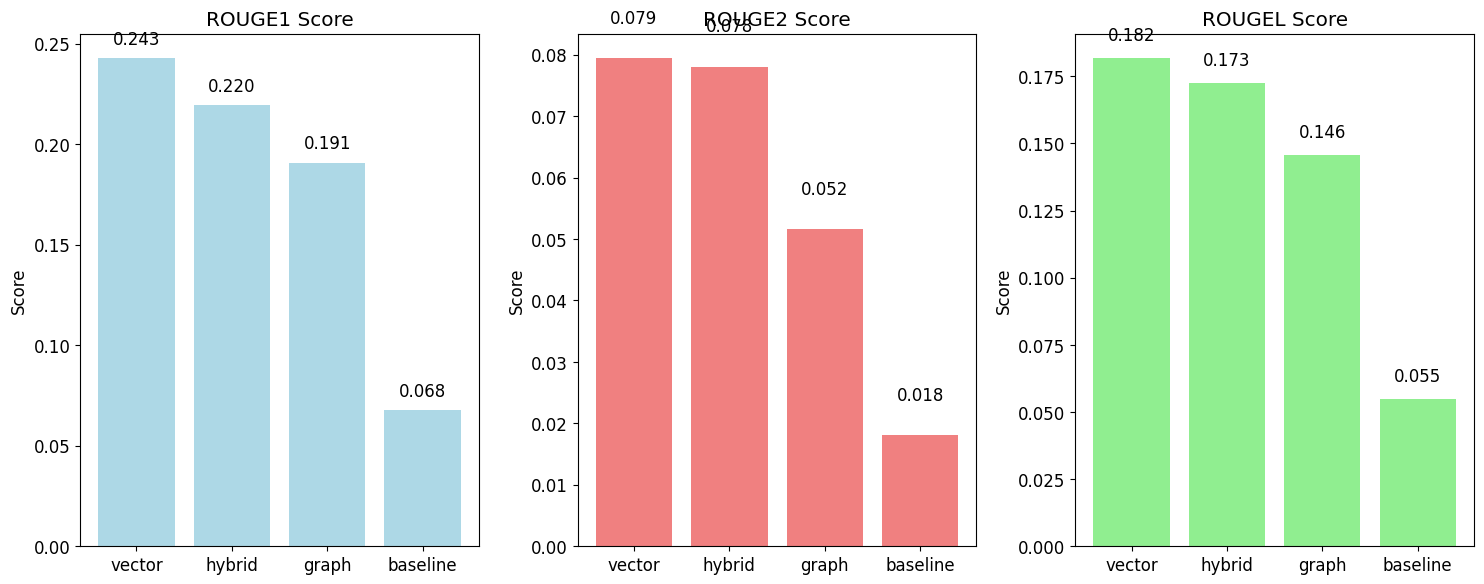

ROUGE Score Zusammenfassung:
          rouge1_f  rouge2_f  rougeL_f
method                                
baseline    0.0677    0.0181    0.0550
graph       0.1908    0.0517    0.1458
hybrid      0.2195    0.0781    0.1726
vector      0.2428    0.0794    0.1818


In [29]:
if eval_df is not None and 'rouge1_f' in eval_df.columns:
    # ROUGE Scores nach Methode
    rouge_metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f']
    available_rouge = [m for m in rouge_metrics if m in eval_df.columns]
    
    if len(available_rouge) >= 2:
        fig, axes = plt.subplots(1, len(available_rouge), figsize=(5*len(available_rouge), 6))
        
        colors = ['lightblue', 'lightcoral', 'lightgreen']
        
        for i, metric in enumerate(available_rouge):
            rouge_by_method = eval_df.groupby('method')[metric].mean().sort_values(ascending=False)
            
            ax = axes[i] if len(available_rouge) > 1 else axes
            bars = ax.bar(rouge_by_method.index, rouge_by_method.values, color=colors[i])
            ax.set_title(f'{metric.upper().replace("_F", "")} Score')
            ax.set_ylabel('Score')
            
            # Werte auf Balken
            for bar, score in zip(bars, rouge_by_method.values):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{score:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # ROUGE Tabelle
        print("ROUGE Score Zusammenfassung:")
        rouge_summary = eval_df.groupby('method')[available_rouge].mean().round(4)
        print(rouge_summary.to_string())
    else:
        print(f"Nur {len(available_rouge)} ROUGE-Metriken verfügbar: {available_rouge}")
        
else:
    print("Keine ROUGE-Score Daten gefunden.")

## 4. Performance Metriken (wie im Grundprojekt)

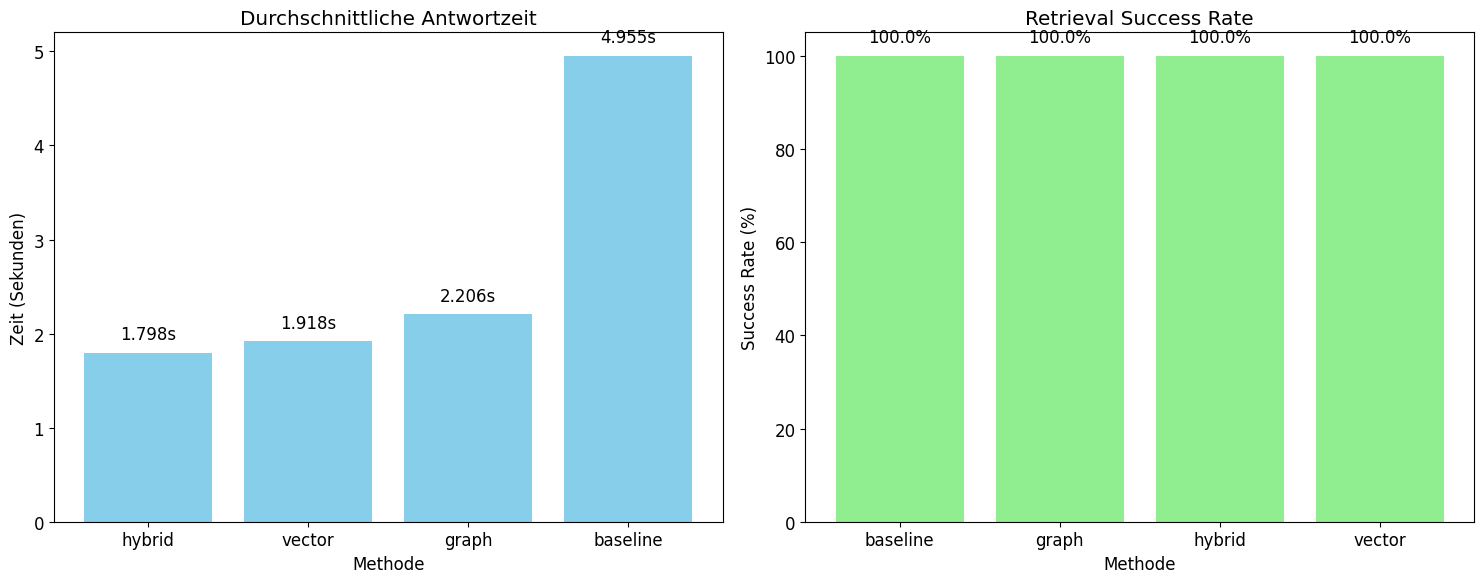

Performance Zusammenfassung:
 Methode  Avg_Zeit_s  Success_Rate_%
  hybrid       1.798           100.0
  vector       1.918           100.0
   graph       2.206           100.0
baseline       4.955           100.0


In [30]:
# Durchschnittliche Antwortzeiten & Success Rates
if 'retrieval_time' in pipeline_df.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Durchschnittliche Antwortzeiten
    time_by_method = pipeline_df.groupby('method')['retrieval_time'].mean().sort_values()
    
    bars1 = ax1.bar(time_by_method.index, time_by_method.values, color='skyblue')
    ax1.set_title('Durchschnittliche Antwortzeit')
    ax1.set_xlabel('Methode')
    ax1.set_ylabel('Zeit (Sekunden)')
    
    # Werte auf Balken
    for bar, time_val in zip(bars1, time_by_method.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + time_by_method.max()*0.02,
                f'{time_val:.3f}s', ha='center', va='bottom')
    
    # Success Rate (Anteil erfolgreicher Retrieval-Operationen)
    if 'success' in pipeline_df.columns:
        success_by_method = pipeline_df.groupby('method')['success'].mean().sort_values(ascending=False)
    else:
        # Fallback: Success = nicht-leere Antworten
        pipeline_df['has_answer'] = pipeline_df['answer'].notna() & (pipeline_df['answer'] != '')
        success_by_method = pipeline_df.groupby('method')['has_answer'].mean().sort_values(ascending=False)
    
    bars2 = ax2.bar(success_by_method.index, success_by_method.values * 100, color='lightgreen')
    ax2.set_title('Retrieval Success Rate')
    ax2.set_xlabel('Methode')
    ax2.set_ylabel('Success Rate (%)')
    ax2.set_ylim(0, 105)
    
    # Werte auf Balken
    for bar, success_rate in zip(bars2, success_by_method.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{success_rate*100:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Performance Tabelle
    print("Performance Zusammenfassung:")
    perf_summary = pd.DataFrame({
        'Methode': time_by_method.index,
        'Avg_Zeit_s': time_by_method.round(3).values,
        'Success_Rate_%': (success_by_method * 100).round(1).values
    })
    print(perf_summary.to_string(index=False))
    
else:
    print("Keine Performance-Daten (retrieval_time) gefunden.")

## 5. Finale Ergebnisse Dashboard (4-Panel Übersicht wie im Grundprojekt)

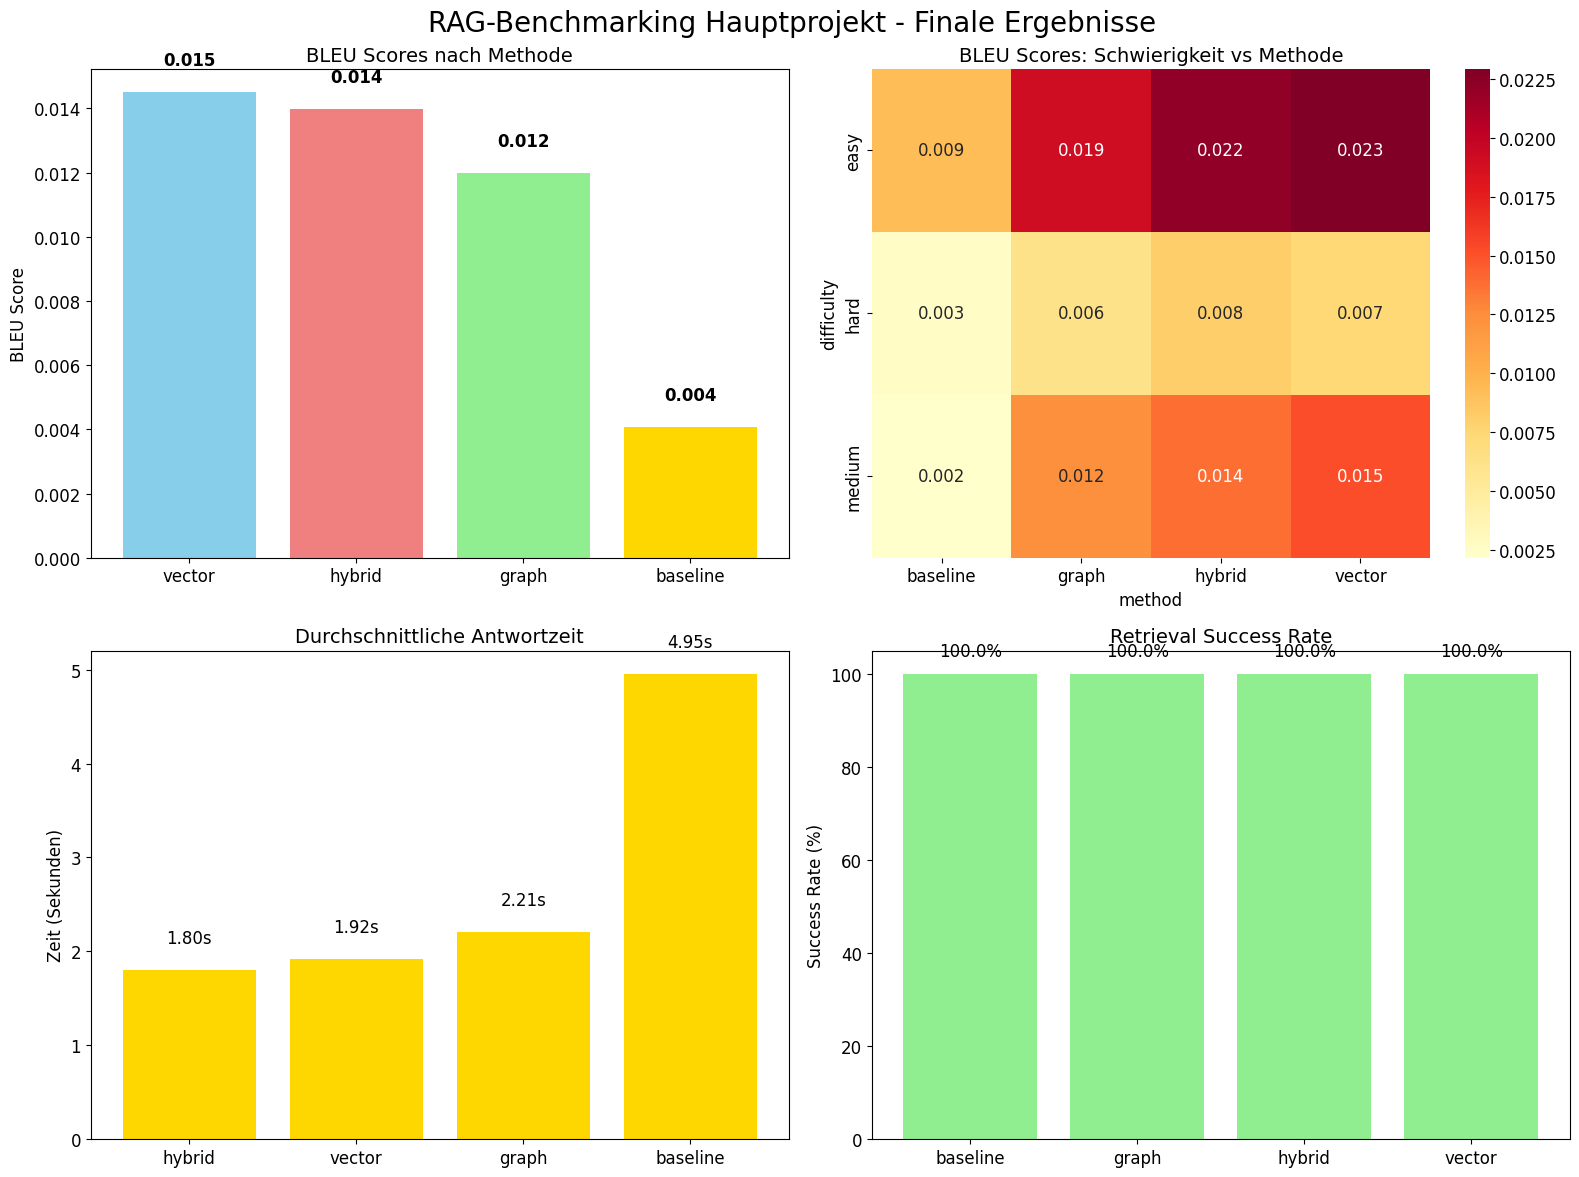

In [31]:
# Finale Zusammenfassung in 4-Panel Layout
if eval_df is not None and 'bleu_score' in eval_df.columns:
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('RAG-Benchmarking Hauptprojekt - Finale Ergebnisse', fontsize=20, y=0.98)
    
    # Panel 1: BLEU Scores nach Methode
    ax1 = plt.subplot(2, 2, 1)
    bleu_means = eval_df.groupby('method')['bleu_score'].mean().sort_values(ascending=False)
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(bleu_means)]
    bars1 = ax1.bar(bleu_means.index, bleu_means.values, color=colors)
    ax1.set_title('BLEU Scores nach Methode', fontsize=14)
    ax1.set_ylabel('BLEU Score')
    
    # Werte anzeigen
    for bar, score in zip(bars1, bleu_means.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bleu_means.max()*0.05,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Panel 2: BLEU Scores nach Schwierigkeit (falls verfügbar)
    ax2 = plt.subplot(2, 2, 2)
    if 'difficulty' in eval_df.columns and eval_df['difficulty'].nunique() > 1:
        difficulty_pivot = eval_df.pivot_table(values='bleu_score', index='difficulty', 
                                              columns='method', aggfunc='mean')
        sns.heatmap(difficulty_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2, cbar=True)
        ax2.set_title('BLEU Scores: Schwierigkeit vs Methode', fontsize=14)
    else:
        # Alternative: ROUGE-1 falls keine Schwierigkeit
        if 'rouge1_f' in eval_df.columns:
            rouge1_means = eval_df.groupby('method')['rouge1_f'].mean().sort_values(ascending=False)
            bars2 = ax2.bar(rouge1_means.index, rouge1_means.values, color='lightcoral')
            ax2.set_title('ROUGE-1 Scores nach Methode', fontsize=14)
            ax2.set_ylabel('ROUGE-1 Score')
            
            for bar, score in zip(bars2, rouge1_means.values):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + rouge1_means.max()*0.05,
                        f'{score:.3f}', ha='center', va='bottom')
        else:
            ax2.text(0.5, 0.5, 'Schwierigkeits-\nanalyse nicht\nverfügbar', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    
    # Panel 3: Durchschnittliche Antwortzeit
    ax3 = plt.subplot(2, 2, 3)
    if 'retrieval_time' in pipeline_df.columns:
        time_means = pipeline_df.groupby('method')['retrieval_time'].mean().sort_values()
        bars3 = ax3.bar(time_means.index, time_means.values, color='gold')
        ax3.set_title('Durchschnittliche Antwortzeit', fontsize=14)
        ax3.set_ylabel('Zeit (Sekunden)')
        
        for bar, time_val in zip(bars3, time_means.values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + time_means.max()*0.05,
                    f'{time_val:.2f}s', ha='center', va='bottom')
    else:
        ax3.text(0.5, 0.5, 'Keine\nPerformance-\nDaten', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        ax3.set_title('Performance-Daten fehlen', fontsize=14)
    
    # Panel 4: Success Rate
    ax4 = plt.subplot(2, 2, 4)
    if 'success' in pipeline_df.columns:
        success_rates = pipeline_df.groupby('method')['success'].mean().sort_values(ascending=False)
    else:
        pipeline_df['has_answer'] = pipeline_df['answer'].notna() & (pipeline_df['answer'] != '')
        success_rates = pipeline_df.groupby('method')['has_answer'].mean().sort_values(ascending=False)
    
    bars4 = ax4.bar(success_rates.index, success_rates.values * 100, color='lightgreen')
    ax4.set_title('Retrieval Success Rate', fontsize=14)
    ax4.set_ylabel('Success Rate (%)')
    ax4.set_ylim(0, 105)
    
    for bar, rate in zip(bars4, success_rates.values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
                f'{rate*100:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
else:
    print("Unvollständige Daten - kann finales Dashboard nicht erstellen.")

## 6. Experiment-Metadaten und Zusammenfassung

In [32]:
# Experiment-Zusammenfassung
print("=" * 80)
print("                    EXPERIMENT ZUSAMMENFASSUNG")
print("=" * 80)

# Grundlegende Statistiken
num_methods = pipeline_df['method'].nunique() if 'method' in pipeline_df.columns else 0
num_questions = pipeline_df['question_id'].nunique() if 'question_id' in pipeline_df.columns else 0
total_runs = len(pipeline_df)

print(f"Getestete Methoden: {num_methods}")
print(f"Anzahl Fragen: {num_questions}")
print(f"Gesamt-Durchläufe: {total_runs}")

if eval_df is not None and 'bleu_score' in eval_df.columns:
    # Beste Methode identifizieren
    best_method_bleu = eval_df.groupby('method')['bleu_score'].mean().idxmax()
    best_bleu_score = eval_df.groupby('method')['bleu_score'].mean().max()
    
    print(f"\nBeste Methode (BLEU): {best_method_bleu}")
    print(f"Bester BLEU Score: {best_bleu_score:.4f}")
    
    # Performance-Improvement vs Baseline
    if 'baseline' in eval_df['method'].values:
        baseline_bleu = eval_df[eval_df['method'] == 'baseline']['bleu_score'].mean()
        if best_bleu_score > baseline_bleu and baseline_bleu > 0:
            improvement = ((best_bleu_score - baseline_bleu) / baseline_bleu) * 100
            print(f"Verbesserung vs Baseline: {improvement:.1f}%")

# Report-Daten falls verfügbar
if report_data and 'experiment_metadata' in report_data:
    metadata = report_data['experiment_metadata']
    print(f"\nExperiment-Name: {metadata.get('name', 'N/A')}")
    print(f"Gesamtlaufzeit: {metadata.get('total_runtime', 0):.2f}s")
    print(f"Timestamp: {metadata.get('timestamp', 'N/A')}")

print("\n" + "=" * 80)
print("Analyse abgeschlossen. Alle Diagramme wurden generiert.")
print("=" * 80)

                    EXPERIMENT ZUSAMMENFASSUNG
Getestete Methoden: 4
Anzahl Fragen: 12
Gesamt-Durchläufe: 48

Beste Methode (BLEU): vector
Bester BLEU Score: 0.0145
Verbesserung vs Baseline: 256.0%

Experiment-Name: rag_benchmark_comparison_20250827_184001
Gesamtlaufzeit: 159.94s
Timestamp: 2025-08-27 18:42:41

Analyse abgeschlossen. Alle Diagramme wurden generiert.


## 7. Export für Dokumentation

In [33]:
# Zusammenfassung für Dokumentation exportieren
doc_summary = {
    'experiment_info': {
        'methods_tested': list(pipeline_df['method'].unique()) if 'method' in pipeline_df.columns else [],
        'total_questions': num_questions,
        'total_runs': total_runs
    }
}

if eval_df is not None and 'bleu_score' in eval_df.columns:
    # BLEU-Statistiken
    bleu_stats = eval_df.groupby('method')['bleu_score'].agg(['mean', 'std', 'count']).round(4)
    doc_summary['bleu_results'] = bleu_stats.to_dict()
    
    doc_summary['best_method'] = {
        'name': best_method_bleu,
        'bleu_score': round(best_bleu_score, 4)
    }

if 'retrieval_time' in pipeline_df.columns:
    time_stats = pipeline_df.groupby('method')['retrieval_time'].agg(['mean', 'std']).round(3)
    doc_summary['performance'] = time_stats.to_dict()

# Export als JSON für Dokumentation
output_path = results_dir / 'analysis_summary_for_docs.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(doc_summary, f, indent=2, ensure_ascii=False)

print(f"Dokumentations-Summary exportiert: {output_path}")
print("\nKann für Thesis-Abbildungen und Tabellen verwendet werden.")

Dokumentations-Summary exportiert: ..\results\analysis_summary_for_docs.json

Kann für Thesis-Abbildungen und Tabellen verwendet werden.
